<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red"> r0825483, r0653687, r0823967, r0820202, r0822886</span>.

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 0* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/b7a2a8743bd842ca9ac93ae91cbc8d9f) prior to the deadline on **Tuesday June 6th 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 1* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 0 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
!pip install tensorflow_addons
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
import cv2
import random
from tqdm import tqdm

#importing sklearn library
from sklearn.svm import LinearSVC
import sklearn
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

#Modules for segmentation
!pip install segmentation-models
%env SM_FRAMEWORK=tf.keras
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
print(sm.__version__)
sm.set_framework('tf.keras')
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

#Modules image augmentations
!pip install -U albumentations

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

In [ ]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computervision-groupassignment1/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computervision-groupassignment1/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computervision-groupassignment1/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [ ]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computervision-groupassignment1/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computervision-groupassignment1/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

Code for resize the images to same shape as required to enable model training 

In [ ]:
#Resize image 
def resize_image(array_of_images,target_size):
    return np.array(list(map(lambda x:cv2.resize(x, target_size, interpolation = cv2.INTER_AREA) , array_of_images)))


# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

Converting the data in data frame to resized image to obtain train and test image for classification task

In [ ]:

'''
    Create train image , label and seg varibale with resized image size
'''
image_shape = (600,600)
no_of_classes = 20
classes_names = train_df.columns[0:20].tolist()

train_images           = train_df['img'].to_numpy()
X_train                = resize_image(train_images,image_shape)

Y_train                = train_df.iloc[:,0:-2].to_numpy()

train_segmentation     = train_df['seg'].to_numpy()
X_seg                  = resize_image(train_segmentation,image_shape)

'''
    Create test image , label and seg varibale 
'''

test_images       = test_df['img'].to_numpy()
X_test            = resize_image(test_images,image_shape)

print("Train images shape: " , X_train.shape)
print("Train labels shape: " , Y_train.shape)
print("Train segmentation shape: " , X_seg.shape)

print("Test images shape: " , X_test.shape)

In [ ]:
# plotting train and test seg images with the img class labels
for idx, i in enumerate(range(0,5)):
    for j in np.where(Y_train[i]==1)[0]:
        print(idx, classes_names[j],end="  ")
    plt.subplot(1,2,1)
    plt.imshow(X_train[i])
    plt.subplot(1,2,2)
    plt.imshow(X_seg[i])
    plt.show()

## 2.1 Approch for Image Classification?

We have 749 images for training and 750 images of testing which are distributed over 20 classes. [Aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor].
This is a multilabel multiclass problem and to tackle this we tried Deep learning as well as Deep Learning + classical machine learning. 
Based on our testing and analysis on train data, we decided to use Deep Learning (Efficient Net[1] trained on ImageNet) for feature extraction + SVM (RBF kernel) as classifier.
Below table shows the performance for various techniques we tried.

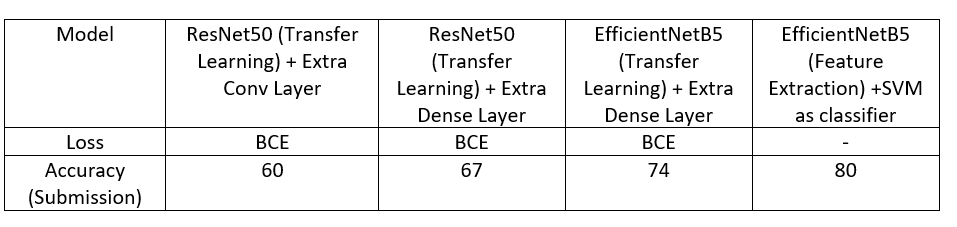

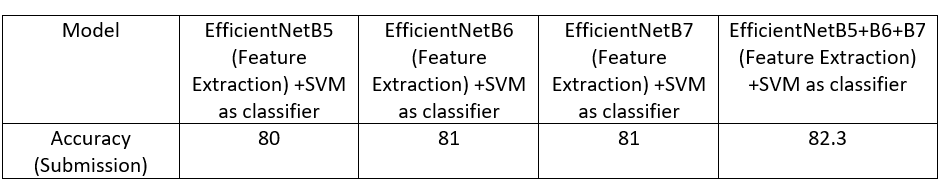

Based on the above analysis we decided to go with the using a PreTrained Model on ImagNet for feature extraction and SVM as a classifier. This works well for our train data because the amount of train data is less given that we have 20 classes and many images have more than one class in them. SVM  creates 20 different decision boundaries for each class as binary classifier ensuring generalized decision boundary. 

To enable SVM to predict for multi label we used multilabel_classifier[3] functionality from sklearn and passed svm as object to it. This made the Multi-Label predicition possible with SVM.

For EfficientNet to work at full efficiency we resized the images to (600, 600) [2], increasing the size of image is helping us to give better results. 

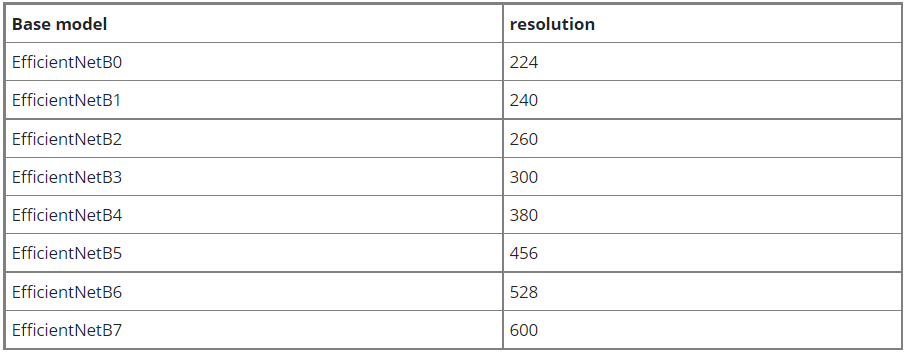


Thus we choose the best model we obtained as EfficientNetB5+B6+B7 (Feature Extraction) + SVM as classifier with input image size as (600,600) . So, for this model the hyper parameters are choosen from the logic below.

HYPER PARAMETER TUNING:

THRESHOLD: To obtain the best threholds we loop the threshold from 0 to 1 with a range of 0.05, and used custom dice loss to evalaute the best threshold. We obtained 0.49 as the threshold for our best model. [Used predict proba from SVM to get the prediction probability of every class]

SVM C and Gamma: Since we use multilabel_classifier we were not able to use gridseachCV with svm to tune C and gamma. So we manually tuned them through for loop to obtain the optimal value. The optimal value obtained for C is 1 and Gamma is 0.002

[1] Tan, M., & Le, Q. (2019, May). Efficientnet: Rethinking model scaling for convolutional neural networks. In International Conference on Machine Learning (pp. 6105-6114). PMLR.

[2] https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

[3] https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html


In [ ]:
class EfficientNetClassificationModel:
    """
    Random classification model: 
        - generates random labels for the inputs based on the class distribution observed during training
        - assumes an input can have multiple labels
    """
    def __init__(self):
        
        #EfficientNetB7 model trained on imagenet loaded
        backbone_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape = (image_shape[0],image_shape[1],3))
        backbone_model.trainable = False   
        x = tf.keras.layers.GlobalAveragePooling2D(name='g_avg_pool')(backbone_model.output)
        self.model_b7 = tf.keras.Model(backbone_model.input,x)
        
        #EfficientNetB6 model trained on imagenet loaded
        backbone_model = tf.keras.applications.EfficientNetB6(include_top=False, weights='imagenet', input_shape = (image_shape[0],image_shape[1],3))
        backbone_model.trainable = False   
        x = tf.keras.layers.GlobalAveragePooling2D(name='g_avg_pool')(backbone_model.output)
        self.model_b6 = tf.keras.Model(backbone_model.input,x)
        
        #EfficientNetB5 model trained on imagenet loaded
        backbone_model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_shape = (image_shape[0],image_shape[1],3))
        backbone_model.trainable = False   
        x = tf.keras.layers.GlobalAveragePooling2D(name='g_avg_pool')(backbone_model.output)
        self.model_b5 = tf.keras.Model(backbone_model.input,x)
        
        #SVM model initialized with tuned hyper parameter
        svm_model = SVC(random_state=42, probability = True, C=1, gamma=0.002)
        
        # Make it an Multilabel classifier
        self.multilabel_classifier = MultiOutputClassifier(svm_model, n_jobs=-1)
        
    def feature_extraction(self, data_list):
        #Extract feature for every image from all the three EfficientNet model concatenated
        feature_extracted = []
        for i in tqdm(range(0,len(data_list))):
            tmp = np.expand_dims(data_list[i],axis=0)
            f1 = self.model_b7(tmp)
            f2 = self.model_b6(tmp)
            f3 = self.model_b5(tmp)
            
            f = np.concatenate((f1,f2,f3),axis=-1)
            feature_extracted.append(f)
            
        return np.array(feature_extracted)
        
    def fit(self, X, y):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        #Extracted feature for train data
        XExtracted = self.feature_extraction(X)[:,0,:]

        #Fitting the train data with the classifier
        self.multilabel_classifier.fit(XExtracted, y)

        
    def predict(self, X):
        """
        Predicts for each input a label.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        y_pred: list of arrays - n x (nb_classes)
        y_test_pred: list of arrays - n x (confidences )
        """
        
        #Extracted feature for train data
        XExtracted_test = self.feature_extraction(X)[:,0,:]
        
        #Predicition of classifier on test data
        y_test_pred = self.multilabel_classifier.predict_proba(XExtracted_test)
        y_test_pred = np.transpose(np.array(y_test_pred)[:,:,1])
        Y_pred = np.where(y_test_pred > 0.49, 1 ,0)
        
        return Y_pred, y_test_pred
    


In [ ]:
#initilize the class object
classification = EfficientNetClassificationModel()

#train the model
classification.fit(X_train,Y_train)

In [ ]:
#predict on test data
ret_pred, ret_conf = classification.predict(X_test)

#writing the prediction to test dataframe
test_df.loc[:, classes_names] = ret_pred

In [ ]:
#Creating sub image fro adversial attacks
X_adversial = X_train[0:10]
Y_adversial = Y_train[0:10]

In [ ]:
del train_images
del train_segmentation

# 3. Semantic segmentation
# 3.1 The network
The goal here is to implement a semantic segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes + BG . Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

For semantic segmentation we are using U-net [1] architecture with efficientNetB5 pretrained on ImageNet as the encoder.

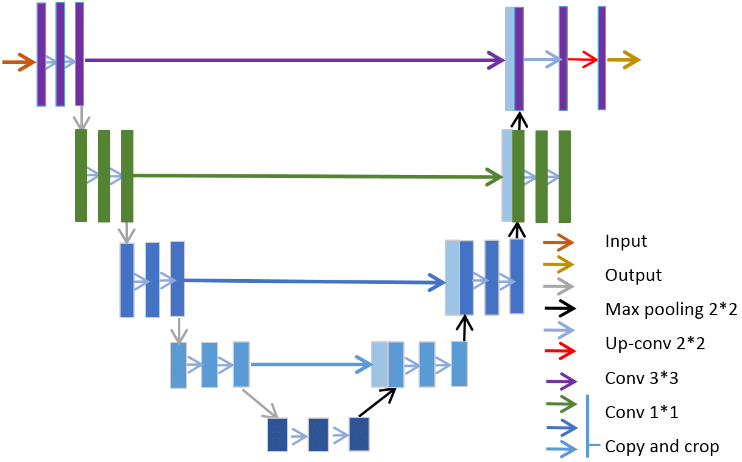

Data: We perfom agumentation on given 749 train images and genearte a total of around 2700 images. Thus we get around 3500 images for training the semantic segmentation model. We chosse the amount of agumentation for each class images to ensure uniform distribution amoung all classes. 

Encoder : Same as  classifier we tried using well known architecures like ResNet, InceptionResNetV2 and EfficientNet as encoder for segmentation. We obtained the best results when we were using the EfficientNetB5 as the encoder.
All the layers in Encoder are freezed for training.

Decoder: Untrained layers are initilized connecting with the encoder using U-Net architecture. Around 8M paramameters are part of the Decoder for training the semantic segementation model

Input shape: Resized the image to (512,512) instead of (600,600) as in classfier to avoid memory issues.

Output Shape: The output for a image from the model prediction is same as input in height and weight, the depth is equal to 1(Background) + Total_classes (20 in our case).

Loss: Sparse Category Crossentropy [2]

We avoided encoding the label provided for train and test segemation images to depth 21 by using sparse category crossentrpy which does this in backend. We tried various custom loss but SCC produced better results.


[1] Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[2] https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [ ]:
'''
    Create train image , label and seg varibale 
'''
image_shape = (512,512)
no_of_classes = 20
classes_names = train_df.columns[0:20].tolist()

train_images           = train_df['img'].to_numpy()
X_train                = resize_image(train_images,image_shape)

Y_train                = train_df.iloc[:,0:-2].to_numpy()

train_segmentation     = train_df['seg'].to_numpy()
X_seg                  = resize_image(train_segmentation,image_shape)

'''
    Create test image , label and seg varibale 
'''

test_images       = test_df['img'].to_numpy()
X_test            = resize_image(test_images,image_shape)

print("Train images shape: " , X_train.shape)
print("Train labels shape: " , Y_train.shape)
print("Train segmentation shape: " , X_seg.shape)

print("Test images shape: " , X_test.shape)

In [ ]:
'''

    The block is used to do image agumentation for image and crossponding seg image.


'''


#If False is used because loading the image is casuing out of memory issues [Can be loaded in a system with 20GB RAM]
if False:

    import albumentations as A
    
    #Different types of random agumentation
    transform = A.Compose([
        A.GaussianBlur(p=0.3),
        A.HorizontalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(p=0.3)
    ])

    count_list =[]
    for i in range(20):
        count_list.append(sum(np.where(Y_train[:,i]==1,True,False)))

    image_count_sorted_list = np.argsort(np.array(count_list))[::-1]

    X_agumented_train = []
    Y_agumented_train = []
    X_seg_augumented_train = []

    image_count_threshold = 500

    #Loop to generate Agumented images
    for i in image_count_sorted_list:
        if(count_list[i] > image_count_threshold):
            continue
        else:
            
            #varying image threshold for diffenr class to get equal distribution
            
            if i==14:

                image_count_threshold = 375
                class_image_idx = class_image_idx = np.where(Y_train[:,i]==1)


            elif i==9 or i==6 or i==7 or i==4 or i==11 or i==10  or i==15:

                image_count_threshold = 250
                class_image_idx = np.where((Y_train[:,i]==1) & (Y_train[:,14]!=1))     

            else:

                image_count_threshold = 150
                class_image_idx = np.where((Y_train[:,i]==1) & (Y_train[:,14]!=1))

            number_of_image_to_augument = image_count_threshold - len(class_image_idx[0])

            for j in range(number_of_image_to_augument):
                random_idx = random.choice(class_image_idx[0])

                transformed = transform(image=X_train[random_idx], mask=X_seg[random_idx])
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']

                X_agumented_train.append(transformed_image)
                Y_agumented_train.append(Y_train[random_idx])
                X_seg_augumented_train.append(transformed_mask)

    #converting agumented image into numpy array
    X_agumented_train = np.array(X_agumented_train)  
    Y_agumented_train = np.array(Y_agumented_train)
    X_seg_augumented_train = np.array(X_seg_augumented_train)

    chair_idx = np.where(Y_agumented_train[:,8]==1)[0][0:250]

    X_agumented_train = np.delete(X_agumented_train,chair_idx, axis=0)
    Y_agumented_train = np.delete(Y_agumented_train,chair_idx, axis=0)
    X_seg_augumented_train = np.delete(X_seg_augumented_train,chair_idx, axis=0)

    #Concatenating original data with agumented data
    X_new = np.concatenate([X_train, X_agumented_train],axis=0)
    Y_new = np.concatenate([Y_train, Y_agumented_train],axis=0)
    X_seg_new = np.concatenate([X_seg, X_seg_augumented_train],axis=0)

    # Split into training and testing data for segmentation
    X_train_s , X_val_s, Y_train_s, Y_val_s  = train_test_split(X_new, X_seg_new, test_size=0.2, random_state=42)

    del X_agumented_train
    del Y_agumented_train
    del X_seg_augumented_train
    del X_train
    del Y_train
    del X_seg


    print('The new image data size is : '+ str(X_new.shape))
    print('The new label size is : '+ str(Y_new.shape))
    print('The new seg image data size is : '+ str(X_seg_new.shape))

    for i in range(20):
        print('class name: ' + str(i) + '  ' + str(classes_names[i]) + ' count: ' +str(sum(np.where(Y_new[:,i]==1,True,False))))


## 3.2 Postprocessing the segmentation output

1. The output mask is obtained from the segmentation model prediction
2. For any class segmentation mask with total pixel count predicted, if less than a threshold is converted to BackGround(0)
3. For any class segmentation mask, if its not in the predicition done by the classification model then its converted to BackGround(0). [ This enusred less False Positive masks generated by the model ]

Thus Cleaning of the segmentation masks prediction by above process enabled us to obtain cleaner segmentation mask as output.

In [ ]:
class UnetSegmentationModel:
    """
    Random segmentation model: 
        - generates random label maps for the inputs based on the class distributions observed during training
        - every pixel in an input can only have one label
    """
    
    def __init__(self):
        BACKBONE = 'efficientnetb5'
        self.preprocess_input = sm.get_preprocessing(BACKBONE)

        self.seg_model  = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=no_of_classes+1, activation='sigmoid', input_shape=(512,512,3))

        for layers in self.seg_model.layers:
            if layers.name!= 'top_activation':
                layers.trainable = False
            else:
                break  
        
    def fit(self, X, Y):
        """
        Adjusts the class ratio variable to the one observed in Y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        Y: list of arrays - n x (height x width)

        Returns
        -------
        self
        """
        
        filepath = 'model_Seg_Submission.hdf5'
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True, mode='auto')
        self.seg_model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
                loss= tf.keras.losses.SparseCategoricalCrossentropy(),
        )
        
        X = self.preprocess_input(X)
        
        self.seg_model.fit(
                   x=X_train_s,    
                   y=Y_train_s,
                   batch_size=6,
                   epochs=20,
                   validation_data=(X_val_s, Y_val_s),
                   callbacks = checkpoint
                )
        
    def load_seg_model(self, path):
        
        self.seg_model = tf.keras.models.load_model(path,compile=False)
        
        
    def predict(self, X, ):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        
        X = self.preprocess_input(X)
        
        #For any class predicition with total pixels less than this threshold then all it's pixel are taken as background.
        c_thresh = 500 
        
        #For any prediction not predicted by classifier but predicted by segmentation and having more than 10k pixels are considered as predicition
        classification_threshold = 10000
        
        Yseg_pred=[]

        for i in tqdm(range(len(X))):
            tmp = np.expand_dims(X[i],axis=0)
            tmp = self.seg_model.predict(tmp)[0] 
            tmp = np.argmax(tmp,axis=-1)   

            #taking all the classes predicted in segmentation with the count of pixels
            unique_elements, counts_elements = np.unique(tmp, return_counts=True)
            for u_e, c_e in zip(unique_elements, counts_elements):
                
                #If for any class the total pixel predicted is less than c_thresh its taken as background (0)
                if c_e < c_thresh:
                    tmp[np.where(tmp==u_e)] = 0
                
                #If for any class the total pixel predicted is greater than classification_threshold its considered as predicted in classifier
                if c_e > classification_threshold and u_e!=0:             
                    ret_pred[i][u_e-1] = 1  

            no_pred = np.where(ret_pred[i]==0)[0]

            if(len(no_pred)==no_of_classes):
                pass
            else:
                #For any prediction not in the modified classifier prediction but predicted by segmentation is considered as background
                for j in no_pred:
                    tmp[np.where(tmp==j+1)] = 0     

            Yseg_pred.append(tmp)
            
            #Cleaning of the segmentation prediction using classifier prediction enabled us to obtain cleaner segmentation mask as output

        Yseg_pred= np.array(Yseg_pred)
        
        return Yseg_pred

In [ ]:
segmentationModel = UnetSegmentationModel()

#If False is used because loading the image for training casuing out of memory issues so cannot train [Can be loaded and trained in a system with 20GB RAM]
if False:
    segmentationModel.fit(X_new,X_seg_new)

In [ ]:
#Loading the pre-trained model
segmentationModel.load_seg_model('../input/segmentationb5/model_seg_submission.hdf5')
ret_seg_pred = segmentationModel.predict(X_test)

In [ ]:
'''

    Resizing the predicited test data segmentation to the original test data shape for submission
    
'''

check_test = np.array(test_df['seg'].to_list())

for i in range(len(test_df)):
    op_shape = test_df['seg'][i].shape
    tmp = ret_seg_pred[i].reshape((512,512)).astype('float32') 
    op_image = cv2.resize(tmp, (op_shape[1], op_shape[0]) , interpolation = cv2.INTER_AREA)
    #adding the test data prediction to the dataframe
    test_df['seg'][i] = op_image
    
for i in range(len(X_test)):    
    assert test_df['seg'][i].shape==check_test[i].shape

In [ ]:
#Adding the modified classification predicition obtained from segmentation 
test_df.loc[:, classes_names] = ret_pred

In [ ]:
'''

    Plotting the segmentation mask results on test data

'''

%matplotlib inline
for i in range(300,310):
    
    print(i)
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])    
    
    plt.subplot(1,2,2)
    plt.imshow(ret_seg_pred[i])
    plt.show()
    
    print(np.unique(ret_seg_pred[i]),end=' ')
    
    idx=1
    plt.figure(figsize=(15, 15), dpi=80)
    for j in np.unique(ret_seg_pred[i]):
        
        if j==0:
            continue
        
        print(classes_names[j-1], end=' ') 
        plt.subplot(1,10,idx)
        
        plt.imshow(np.where(ret_seg_pred[i]==j,1,0))
        idx+=1
    
    plt.show()    
    
    print("NEW")

## 3.2 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [ ]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

In [ ]:
generate_submission(test_df)

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

# 4. Adversarial attacks 

The network so far has proven to perform exceptionally well. These results are one of the main reasons that deep neural networks, and particularly CNN, have gained great popularity over the last years. But these networks are not perfect just yet. For a neural network to learn, it requires large amounts of data that are usually provided as rather clean. Such setup is therefore very unrealistic, as real world data are not as "nice", and this could cause problems for our network. An example of this could be a selfdriving car wrongly classifying a road sign due to something as simple as a sticker or a line of graffiti, as shown by [Eykholt et al. 2017](https://arxiv.org/abs/1707.08945). We can understand intuitively that blocking out section of an image makes it harder to recognise (such as censor bars). But when working with digital images however, this perturbations can be so subtle that they are not visible for the human eye. Neural nets on the other hand can pick on these fluctuations in the pixel values. [Goodfellow et al. 2015](https://arxiv.org/abs/1412.6572) amongst others, showed how adding seemingly random noise to an image can confuse a neural network into wrongly classifying an object. The following figure from said paper, shows how both before and after the addition of the noise, the image looks like a panda, but the network classifies it as a gibbon.

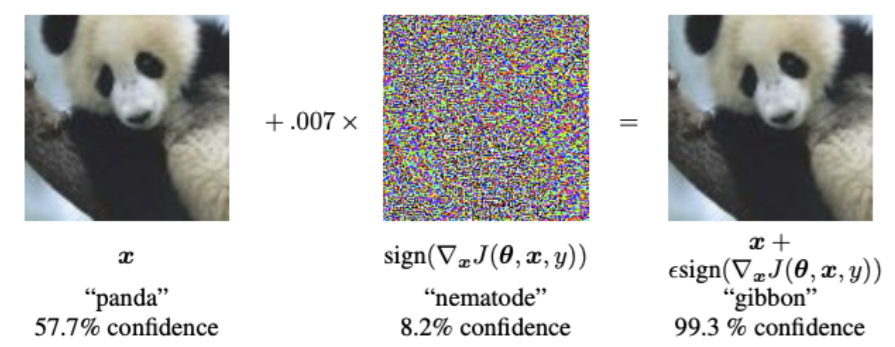

Another example of the impact of misclasification in the real world was presented by [Sharif et al. 2019](https://arxiv.org/abs/1801.00349), where the authors managed to trick a facial recognition network using the adversarial noise 3D printed as glasses. This research proves that this is a topic worth investigating.

In this example we will try to fool the network into thinking it sees a cow. To know what kind of noise needs to be generated we first need to know more about the loss function of the network. To achieve this we can pass an image through the network and track the changes in the gradient. So first we define a function which will look for the pattern. This function will try to find the gradient which minimises the loss to the target label, and maximise the loss to the real label.

In [ ]:
def find_pattern(image, label, target, delta):
    # Format the images correctly
    image = tf.cast(image, tf.float32)   
    delta = tf.cast(delta, tf.float32)  
    image = tf.Variable(image)
    delta = tf.Variable(delta)
    for step in range(0, 100):
        # Record our gradients
        with tf.GradientTape() as tape:
            # Tracked perturbation image for gradient updates
            tape.watch(delta)
            # Add our perturbation vector to the base image
            adversary = image + delta
            # Pass adversarial image through the network and determine the losses to the actual label and target label
            predictions  = classification.model_b5(adversary, training=False)
            originalLoss = -tf.keras.losses.MSE(label,  predictions)
            targetLoss   =  tf.keras.losses.MSE(target, predictions)
            totalLoss = originalLoss + targetLoss
            # Show progress
            if step % 10 == 0:
                print("step: {}, loss: {}...".format(step, totalLoss.numpy()))
        # Calculate the gradients of loss
        gradients = tape.gradient(totalLoss, delta)
        # Update the perturbation
        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(tf.sign(delta))
        
    #Return the perturbation image
    return delta

This function returns the proper noise to add to the original image to trick the model into thinking that the result is of a different class, in our case a cow, or at least it will make the model less confident in its classification. With the pattern function in place, we can test it on a single image and plot both the pertrbations and the resulting image. To get the network to predict the cow, we first load the trained classifier. Then we make it predict the original image, the generated noise and the image with the added noise.

We will take a random image from the training data set as an example to create a perturbation for it. This example is a picture of a train with a person

In [ ]:
#First we will select an image to perturb
n = 7

image = X_adversial[n]
image = image[np.newaxis is None,:,:,:]
#Next, we exctract the features of the image
image_label  = classification.model_b5(image, training=False)

#Here we select a picture of a cow and extract the features
image_target = X_adversial[4] #the image has only cow 
image_target = image_target[np.newaxis is None,:,:,:]
image_target = classification.model_b5(image_target, training=False) 

#Next we will pass the image to create perturbations
perturbations = tf.Variable(tf.zeros_like(image), trainable=True)
perturbations = find_pattern(image, image_label, image_target, perturbations).numpy()

Due to internal functioning of tensor flow, we need to calculate our pattern based on the features rather than the labels. With the perturbations created, we can add the adversarial noise to the originial image. To visualise the effects, we will plot the original image, the noise and the perturbed image, with their most certain classification.

In [ ]:
#Adding the perturbation to the image
adversarial = image+ perturbations * 0.05

#Finding out as what the image is classified
labelim,  confim  = classification.predict(image)
labelper, confper = classification.predict(perturbations)
labeladv, confadv = classification.predict(adversarial)

#Saving the labels
labelim = labelim[0]
labelper = labelper[0]
labeladv = labeladv[0]

#Saving the confidences
confim = confim[0]
confper = confper[0]
confadv = confadv[0]

#Printing the results as figure titles
im_title = ""
per_title = ""
adv_title = ""
for i in range(len(labelim)):
    if labelim[i] == 1 or i ==14:
        im_title += classes_names[i]+": {0:.2f}%  \n".format(confim[i])
        per_title += classes_names[i]+": {0:.2f}%  \n".format(confper[i])
        adv_title += classes_names[i]+": {0:.2f}%  \n".format(confadv[i])

#Plotting the different 
fig, axs = plt.subplots(1, 3, figsize=(10 * 20, 10 * 20))
axs[0].imshow(image[0])
axs[0].set_title(im_title, fontsize=200)
axs[1].imshow(perturbations[0].astype('uint8'), vmin=0, vmax=1)
axs[1].set_title(per_title, fontsize=200)
axs[2].imshow(adversarial[0].astype('uint8'))
axs[2].set_title(adv_title, fontsize=200)

plt.show()

We can see the initial image is classified as we expect. The noise that our adversarial network creates is seemngly random, but is classifed differently than the input image. When we add this noise to the image there is no visible difference. This is because the noise is not very strong in terms of magnitude and in addition it is multiplied by a small value to reduce it even further. Even though our eyes cannot pick up on these changes, the network does see it. The confidence that there is a person in the image drastically lowered.

The adversarial attach fails fails at tricking the classifier completely, as it is not able to make it predict a cow out of the image. However, it does mess up the confidence scores, which can influence the final classification. We can conclude that the way the features have been extracted is not completely robust to this kind of attacks. If we want to improve our network in this sense, we will need to find a way to make it less sensitive to these small variations. The easiest way to achieve this is to feed the network some of these fake examples. This can be done during the training stage or by adding a second training stage with these perturbed images.

# 5. Discussion

There are two parts to the task that we learned how to implement.

1. <b>Multi-Lablel Classification</b>

2. <b>Multi-Label Semantic Segmentation</b>

<b>Multi-Lablel Classification:</b>

This classfication involves classifing more than one class in a given image

<b>Case study 1:</b> Perception of Autnomous vehicles require classfying multiple classs in a given video frame like person, car, truck, bus, traffic light's, etc. to navigate safely. By solving the models which can pereform multilabel classification we can solve this task.

<b>Case Study 2:</b> Question tagging, As we have seen that in stackoverflow each question has several tags, using the knowledge gained from this task we can solve tasks similar to this also.

<b>How to solve Multilabel classification?</b>
Multi label classification is far more complex than a multiclass classification problem because we have two level of complexty here, first, we need to identify how many classes are there for a given input, because for every input we have different no of positive classes. And second, we can't calculate accuracy, precison or any other commonly used metric for proper evaluation of the given model. In our case, we used Dice loss, other possible option is top-k precicion, which is precision for every class averaged.

To identify the proper methoology to solve this particular task we read several research papers given as follows.

1. Deep Residual Learning for Image Recognition https://arxiv.org/pdf/1512.03385.pdf
2. Rethinking the Inception Architecture for Computer Vision https://arxiv.org/pdf/1512.00567.pdf
3. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks https://arxiv.org/pdf/1905.11946.pdf

All the above model are trained on ImageNet and the benchmarked results are given as follows

On furthur reseach we obtained the below plot of models trained on ImageNet (Has classes similar to PASCAL VOC) data.

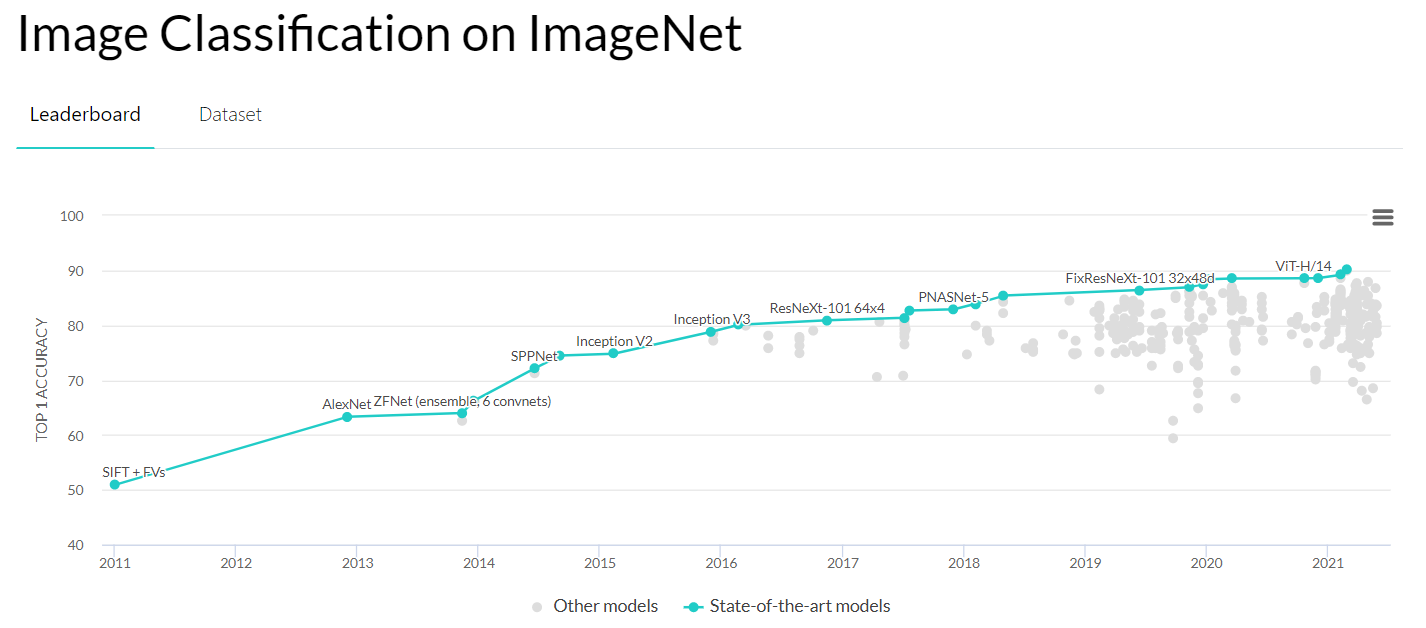


On seeing the tabulated reesults on top-1 and top-5 accuracy as below

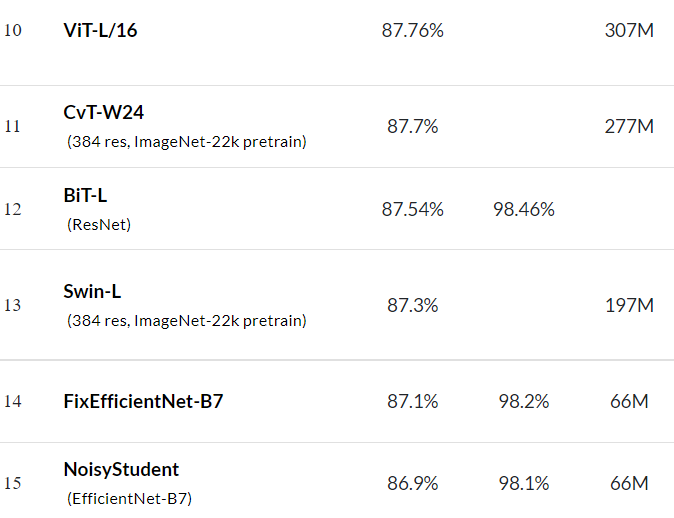

We can observe from the above  image that EfficientNet performed better than other models having similar number of paramters. Other networks which perfromed better than EfficientNet have around 400 million parameters, which is not feasible for us to train on our machines locally.

There are two ways to develop model, 1. using Deep Learning Models with Dense layers for classification or using Classifier like SVM trained from the feature extracted from the DL model. 

After refering to several papers we chose the Deep learning + SVM rather than a pure deep learning classifier.

Thus building on all these research papers we were able to get a really good understanding of solving the multi-label classification problems.


<b>Multi-Lablel Semantic Segementation:</b>

<b>Case study 1:</b> Marking different geogriphical areas in sattelite images like forest cover, mountains, rivers, etc.

<b>Case Study 2:</b> Segmenting different parts of brain scans.

<b>How to solve multilabel Semantic Segmentation?</b>
This is generally solved by an encoder deocder model architecture that classifies each pixel according to all the given classes + background. Encoder basically squeezes the data to lowe dimesnion or low feature images from which decoder scales it to the orginal size in such a way that the original image is converted into a segmentation mask. We also have another segmenation problem called instance segmentation where we generate different mask for each instance of the same class.

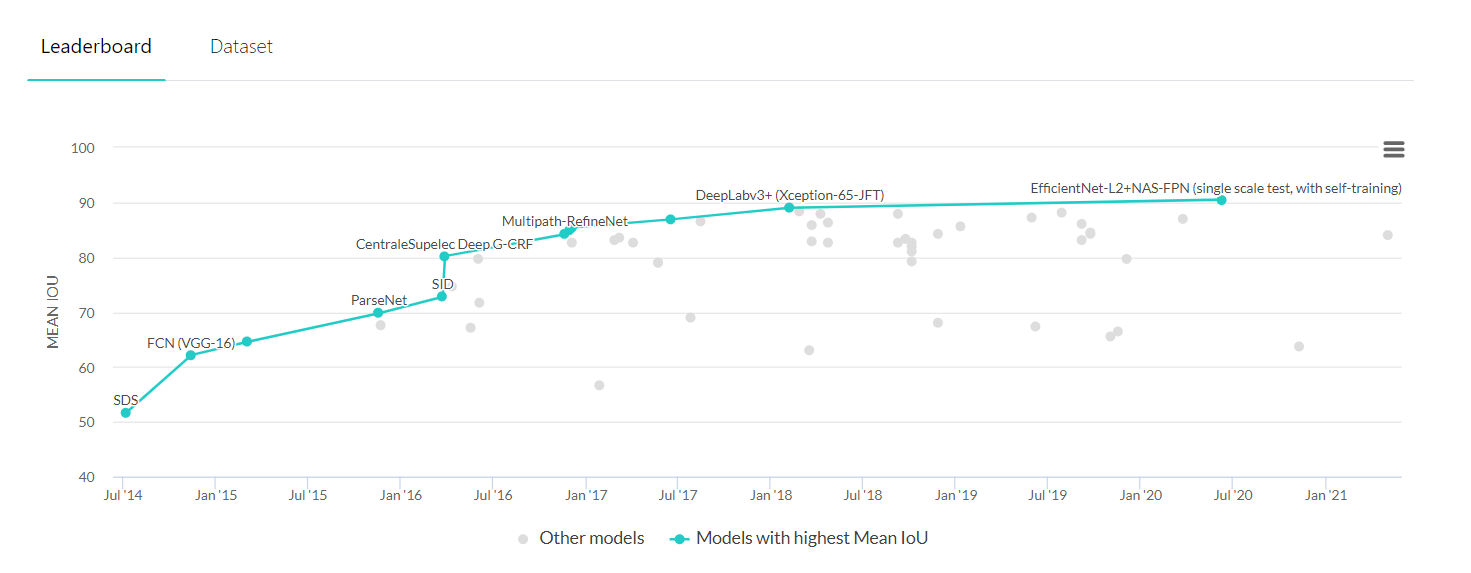

To identify the proper methoology for sematic segementation we identified that U-net works best for our case. Other architectures included DeepLabV3, Linknet, etc. Out of all the tested architectures U-net perfromed the best.

Losses used for semantic segmentation are Dice loss, Jaccard loss, focal loss and Sparse categorical crossentropy. Genrally dice performs the best but due to this being multilabel problem we settled with Sparse categorical Crossentropy.

Based on all our research twe identified that using U-net with EfficientNEt as backbone combined with sparse categrocal crossentropy gives us very good results. 

<b>Thus, by solving this task we learned about both Multilabel classification and Multi label semantic segmentation.</b>

<b>All the Lecture Videos were also part of our learning involved in solving the task</b>